In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from shallow_fbcsp import ShallowFBCSPNet
import pandas as pd
from collections import OrderedDict

In [38]:
def linear_kernel(X):
    """Computes the linear kernel matrix for X."""
    return X @ X.T  # Dot product

def centering_matrix(K):
    """Centers the kernel matrix K."""
    n = K.shape[0]
    H = np.eye(n,dtype=K.dtype) - (1 / n) * np.ones((n, n), dtype=K.dtype)
    return H # Equivalent to HKH

def compute_hsic(X, Y, kernel_X = linear_kernel, kernel_Y = linear_kernel):
    """
    Computes the Hilbert-Schmidt Independence Criterion (HSIC).
    
    Parameters:
    - X: (n_samples, n_features_X) numpy array
    - Y: (n_samples, n_features_Y) numpy array
    - kernel_X: function to compute the kernel matrix for X
    - kernel_Y: function to compute the kernel matrix for Y
    
    Returns:
    - HSIC value (float)
    """
    X = X.to(torch.float32)
    Y = Y.to(torch.float32)
    
    print("kernel x")
    K = kernel_X(X)
    print("kernel Y")
    L = kernel_Y(Y)
    
    K = K.cpu().numpy()
    L = L.cpu().numpy()
    
    print("centering")
    H = centering_matrix(K)
   
    
    Kxy_centered = K @ H @ L @ H
    
    hsic_value = np.trace(Kxy_centered) / ((X.shape[0] - 1) ** 2)
    return hsic_value.item()
  
def compute_CKA(X,Y,kernel_X = linear_kernel,kernel_Y = linear_kernel):
  """
  compute CKA between two X,Y activations
  
  Parameters:
  - X: (n_samples, x_features)
  - Y: (n_samples, y_features)
  - kernel_X: kernel for X
  - kernel_Y: kernel for Y  
  """
  print("compute CKA")
  HSIC_KL = compute_hsic(X,Y,kernel_X,kernel_Y) 
  print("HSIC_KL")
  HSIC_KK = compute_hsic(X,X,kernel_X,kernel_X)
  print("HSIC_KK")
  HSIC_LL = compute_hsic(Y,Y,kernel_Y, kernel_Y)
  print("HSIC_LL")
  
  return HSIC_KL/(np.sqrt(HSIC_KK * HSIC_LL))


In [16]:
# Define model parameters
in_chans = 22
n_classes = 4
n_channels = 22
input_window_samples = 1000
# Load two models for comparison
model= torch.load("braindecode_model_temponly_1.pth",weights_only = False,map_location=torch.device('cpu'))
model2 =ShallowFBCSPNet(in_chans, n_classes, input_window_samples)



In [17]:
print(model)

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 22, 1125]             [1, 4]                    --                        --
├─SafeLog (pool_nonlin_exp): 1-1         [1, 22, 1125]             [1, 22, 1125]             --                        --
├─Ensure4d (ensuredims): 1-2             [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
├─Rearrange (dimshuffle): 1-3            [1, 22, 1125, 1]          [1, 1, 1125, 22]          --                        --
├─Conv2d (conv_time): 1-4                [1, 1, 1125, 22]          [1, 40, 1101, 22]         1,040                     [25, 1]
├─Conv2d (conv_spat): 1-5                [1, 40, 1101, 22]         [1, 40, 1101, 1]          35,200                    [1, 22]
├─BatchNorm2d (bnorm): 1-6               [1, 40, 1101, 1]          [1, 40, 1101, 1]          80                        --
├─Ex

In [18]:
def extract_model_activations(model, input_tensor):
    activations = OrderedDict()

    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    # Register hooks
    for name, layer in model.named_modules():
        if(name == "conv_time" or name == "conv_spat"):
            layer.register_forward_hook(get_activation(name))


    # Run forward pass AFTER registering hooks
    model.eval()
   
    _ = model(input_tensor)  

    return activations  # Return collected activations

In [19]:
import numpy as np
from braindecode.datasets import MOABBDataset

subject_id = [1,2,3,4]
dataset = MOABBDataset(dataset_name="BNCI2014_001", subject_ids=[1,2,3,4,5,6,7,8,9])



from braindecode.preprocessing import (
    exponential_moving_standardize,
    preprocess,
    Preprocessor,
)

low_cut_hz = 4.0  # low cut frequency for filtering
high_cut_hz = 38.0  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000

transforms = [
    Preprocessor("pick_types", eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(
        lambda data, factor: np.multiply(data, factor),  # Convert from V to uV
        factor=1e6,
    ),
    Preprocessor("filter", l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    Preprocessor(
        exponential_moving_standardize,  # Exponential moving standardization
        factor_new=factor_new,
        init_block_size=init_block_size,
    ),
]

# Transform the data
preprocess(dataset, transforms, n_jobs=-1)




c:\Python312\Lib\site-packages\braindecode\preprocessing\preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


In [20]:
from braindecode.preprocessing import create_windows_from_events

trial_start_offset_seconds = -0.5
trial_stop_offset_seconds = 0
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info["sfreq"]
assert all([ds.raw.info["sfreq"] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)
trial_stop_offset_samples = int(trial_stop_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=trial_stop_offset_samples,
    preload=True,
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']

In [21]:
splitted = windows_dataset.split("session")
train_set = splitted['0train']  # Session train
test_set = splitted['1test'] 

In [22]:
print(type(test_set[0][0]))  # Should be <class 'torch.Tensor'>


<class 'numpy.ndarray'>


In [23]:
X = torch.stack([torch.from_numpy(test_set[i][0]) for i in range(len(test_set))])


print(X.shape)  # Verify the tensor shape
print(type(X))  # Should output <class 'torch.Tensor'>


torch.Size([2592, 22, 1125])
<class 'torch.Tensor'>


In [24]:
dummy_input = X

In [25]:
#dummy_input = torch.randn(64, in_chans, input_window_samples)

model_1_activations = extract_model_activations(model,dummy_input)
model_2_activations = extract_model_activations(model2,dummy_input)

print(model_1_activations["conv_time"].shape)
print(model_2_activations["conv_spat"].shape)


torch.Size([2592, 40, 1101, 22])
torch.Size([2592, 40, 1101, 1])


In [26]:
def visualize_comparison(model_1_activations, model_2_activations):
    # Extract the activation tensors from both models
    act_1 = model_1_activations.get('conv_time_spat')
    act_2 = model_2_activations.get('conv_time_spat')

    if act_1 is not None and act_2 is not None:
        # Average activation across all channels
        avg_act_1 = torch.mean(act_1, dim=1).squeeze(0).cpu().numpy()  # Average across channels (C dimension)
        avg_act_2 = torch.mean(act_2, dim=1).squeeze(0).cpu().numpy()
        

        # Plot side-by-side comparison of average activations
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Plot for model 1
        axes[0].imshow(avg_act_1, cmap='viridis')
        axes[0].axis('off')
        axes[0].set_title("Model 1 - Average Activation")

        # Plot for model 2
        axes[1].imshow(avg_act_2, cmap='viridis')
        axes[1].axis('off')
        axes[1].set_title("Model 2 - Average Activation")

        plt.tight_layout()
        plt.show()

        # Plot difference between activations (model 1 - model 2)
        activation_diff = avg_act_1 - avg_act_2
        plt.imshow(activation_diff, cmap='seismic', vmin=-np.max(np.abs(activation_diff)), vmax=np.max(np.abs(activation_diff)))
        plt.colorbar()
        plt.axis('off')
        plt.title("Activation Difference (Model 1 - Model 2)")
        plt.show()

    else:
        print("Could not extract activations for 'conv_time_spat'.")

In [27]:
model_1_activations

OrderedDict([('conv_time',
              tensor([[[[ 1.4068e-01,  1.4068e-01,  1.4068e-01,  ...,  1.4068e-01,
                         -1.4290e-01, -7.2990e-01],
                        [ 1.4068e-01,  1.4068e-01,  1.4068e-01,  ..., -9.0689e-02,
                         -9.8513e-02, -1.4722e-01],
                        [ 1.4068e-01,  1.4068e-01,  1.4068e-01,  ..., -7.4091e-01,
                          3.5576e-03,  7.8484e-01],
                        ...,
                        [ 3.8389e-01,  4.3790e-01,  2.5205e-01,  ...,  6.3086e-01,
                         -1.0766e+00,  1.5031e-01],
                        [ 1.1510e+00,  2.5594e+00,  4.8320e-01,  ..., -4.1871e-01,
                         -9.9009e-01, -1.7429e-01],
                        [ 2.7532e+00,  2.9017e+00,  3.0766e+00,  ..., -2.5168e+00,
                         -1.5374e+00, -5.3402e-01]],
              
                       [[-1.0131e+01, -1.0131e+01, -1.0131e+01,  ..., -1.0131e+01,
                         -9.1426e+0

In [28]:
print("Captured Activations for Model 1:")
for layer_name, activation in model_1_activations.items():

    print(f"{layer_name}: {activation.shape}")
    #print(activation)

Captured Activations for Model 1:
conv_time: torch.Size([2592, 40, 1101, 22])
conv_spat: torch.Size([2592, 40, 1101, 1])


In [29]:
print("Captured Activations for Model 2:")
for layer_name, activation in model_2_activations.items():
    
        print(f"{layer_name}: {activation.shape}")
        print(activation)

Captured Activations for Model 2:
conv_time: torch.Size([2592, 40, 1101, 22])
tensor([[[[ 1.1794,  1.1794,  1.1794,  ...,  1.1794,  1.1724,  1.0618],
          [ 1.1794,  1.1794,  1.1794,  ...,  1.5672,  1.7975,  2.0763],
          [ 1.1794,  1.1794,  1.1794,  ...,  1.6109,  1.6950,  1.0016],
          ...,
          [-0.4691,  0.0906, -0.1039,  ...,  0.9739,  1.4599,  1.4038],
          [-0.7096,  0.4331,  0.2651,  ...,  1.2469,  1.0305,  0.5735],
          [-0.3284,  1.3935,  1.2211,  ...,  0.9636,  0.4403,  0.3402]],

         [[ 0.8027,  0.8027,  0.8027,  ...,  0.8027,  0.3186,  0.6125],
          [ 0.8027,  0.8027,  0.8027,  ...,  1.1998,  1.3647,  1.1084],
          [ 0.8027,  0.8027,  0.8027,  ...,  1.2764,  1.2556,  1.5657],
          ...,
          [ 0.2083,  0.8711,  0.7594,  ...,  1.3513,  0.8094,  0.8236],
          [ 0.4660,  1.7123,  1.2823,  ...,  0.2532,  0.3393, -0.3908],
          [ 0.2183,  1.5115,  1.6389,  ..., -0.2860, -0.1729, -0.2445]],

         [[ 0.3881,  0.3

in:  2
compute CKA
kernel x
kernel Y
centering
HSIC_KL
kernel x
kernel Y
centering
HSIC_KK
kernel x
kernel Y
centering
HSIC_LL
inner layer conv_time done
compute CKA
kernel x
kernel Y
centering
HSIC_KL
kernel x
kernel Y
centering
HSIC_KK
kernel x
kernel Y
centering
HSIC_LL
inner layer conv_time done
layer conv_time done
in:  2
compute CKA
kernel x
kernel Y
centering
HSIC_KL
kernel x
kernel Y
centering
HSIC_KK
kernel x
kernel Y
centering
HSIC_LL
inner layer conv_spat done
compute CKA
kernel x
kernel Y
centering
HSIC_KL
kernel x
kernel Y
centering
HSIC_KK
kernel x
kernel Y
centering
HSIC_LL
inner layer conv_spat done
layer conv_spat done


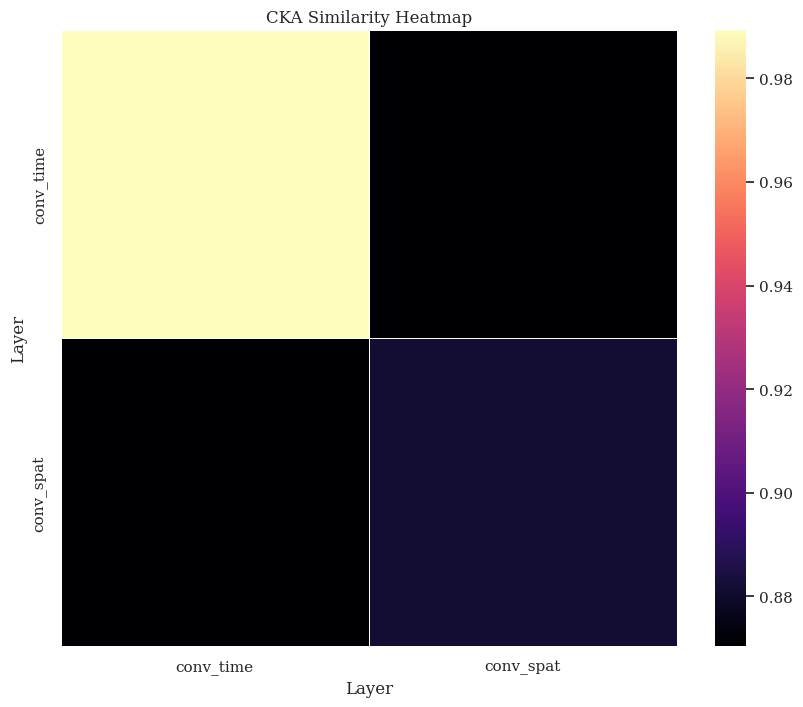

In [ ]:
# Use OrderedDict to preserve the order of layer names
layer_names_model1 = list(model_1_activations.keys())
layer_names_model2 = list(model_2_activations.keys())

cka_similarities = OrderedDict()

# Compute CKA for each layer from model1 and model2
for layer1 in layer_names_model1:
    print("in: ", len(layer_names_model1))
    for layer2 in layer_names_model2:
        activations_x = model_1_activations[layer1].reshape(model_1_activations[layer1].shape[0], -1)
        activations_y = model_2_activations[layer2].reshape(model_2_activations[layer2].shape[0], -1)
        cka_score = compute_CKA(activations_x, activations_y)
        print(f"inner layer {layer1} done")
        
        cka_similarities[(layer1, layer2)] = cka_score
    print(f"layer {layer1} done")

layer_names = list(OrderedDict.fromkeys(layer_names_model1 + layer_names_model2))

# Initialize a square matrix for the CKA similarities
n_layers = len(layer_names)

matrix = np.zeros((n_layers, n_layers))

# Fill the matrix with the CKA similarity values
for (layer1, layer2), similarity in cka_similarities.items():
    i = layer_names.index(layer1)
    j = layer_names.index(layer2)
    matrix[i, j] = similarity
    matrix[j, i] = similarity 

# Create a DataFrame for better visualization
df = pd.DataFrame(matrix, index=layer_names, columns=layer_names)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap='magma', fmt='.2f', square=True, linewidths=0.5, cbar=True)
plt.title('CKA Similarity Heatmap')
plt.xlabel('Layer')
plt.ylabel('Layer')
plt.show()


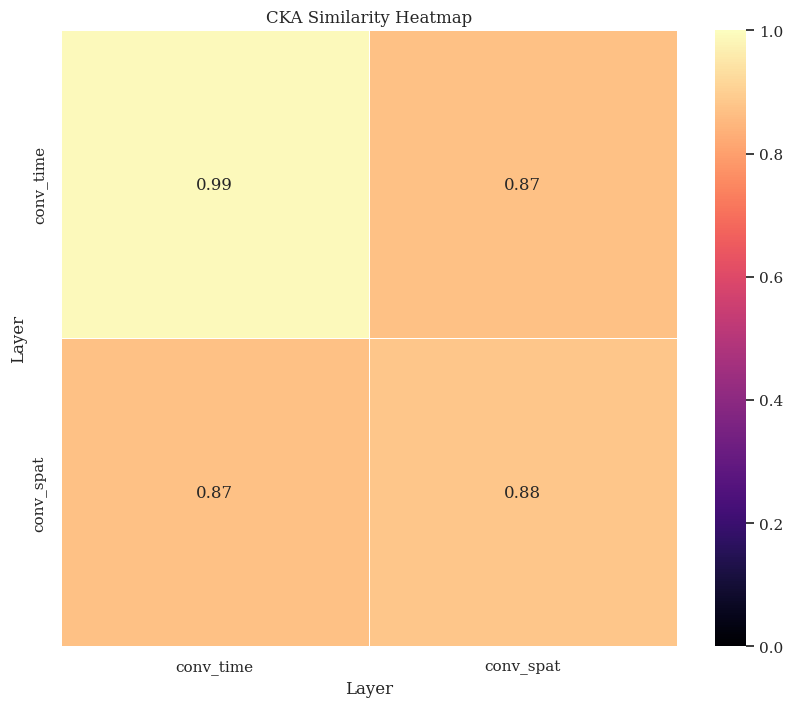

In [42]:
layer_names = list(OrderedDict.fromkeys(layer_names_model1 + layer_names_model2))

# Initialize a square matrix for the CKA similarities
n_layers = len(layer_names)

matrix = np.zeros((n_layers, n_layers))

# Fill the matrix with the CKA similarity values
for (layer1, layer2), similarity in cka_similarities.items():
    i = layer_names.index(layer1)
    j = layer_names.index(layer2)
    matrix[i, j] = similarity
    matrix[j, i] = similarity 

# Create a DataFrame for better visualization
df = pd.DataFrame(matrix, index=layer_names, columns=layer_names)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap='magma', fmt='.2f', square=True, linewidths=0.5, cbar=True, vmin=0, vmax=1)

plt.title('CKA Similarity Heatmap')
plt.xlabel('Layer')
plt.ylabel('Layer')
plt.show()